# Exploring Alumni Interaction and Conversation Dynamics

####  *by Yusuf Abolarinwa*

#### Tags: *Alumni Networks, WhatsApp Conversations, Group Dynamics, Sentiment Analysis, Natural Language Processing (NLP)*

#### - Background 

Education is so much more than the certificates and degrees we receive. It is about the lessons we learn, the people we meet, and the relationships we build along the way. Alumni networks, which are a key part of the educational journey, help keep these relationships alive long after graduation. These networks offer alumni a way to stay connected, share ideas, and continue growing both personally and professionally. 

With instant messaging platforms like WhatsApp being commonly used for closer digital interactions, it is important to stay connected and informed about what’s happening with former peers and how conversations unfold. My project aims to explore the quality of interactions within my department’s alumni WhatsApp group through sentiment analysis. By analyzing the emotions and engagement in these conversations, I seek to provide insights into how we stay connected, share experiences, and continue building relationships after graduation.

#### - Challenges 
              
 - **Privacy and Ethical Considerations:** Analyzing WhatsApp conversations involves accessing potentially sensitive personal data. To address this, I ensure the anonymization of alumni phone numbers and any other identifying details, safeguarding privacy while maintaining ethical standards throughout the analysis process.

 - **Informal Language:** WhatsApp conversations often include slang, emojis, and informal language, which can complicate sentiment analysis. 

 - **Data Noise:** WhatsApp conversations may contain excessive noise, such as irrelevant content, off-topic discussions, or incomplete sentences, which can complicate the sentiment analysis process. Cleaning the data and filtering out irrelevant content is essential to obtaining meaningful insights.


## Import important libraries

In [1]:
import pandas as pd
import numpy as np

import datetime
from os import path
import zipfile
import re
import collections
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx


import emoji
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
import gensim
from gensim import corpora
gensim.utils.random.seed(42)
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import optuna
from gensim.models import LdaModel

import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Read data

#### - Open Whatsapp zip folder & extract text file

In [ ]:
# File paths
zip_path = "C:\\Users\\DELL\\Desktop\\Alumni-Interaction-and-Conversation-Dynamics-NLP\\data\\raw\\WhatsApp Chat with Certified Statisticians.zip"
txt_file_path = "WhatsApp Chat with Certified Statisticians.txt"

# Extract text from ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open(txt_file_path) as file:
        text_block = file.read().decode('utf-8')

#### - Extract chats/posts/messages

In [3]:
# Regular expression to extract messages
pattern = r"(\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{2} ?[APMapm]*) - ([^:]+): (.+)"
matches = re.findall(pattern, text_block)

# Convert to DataFrame
df_raw = pd.DataFrame(matches, columns=["timestamp", "member", "message"])
# df_raw.head()

#### - Anonymization of member's identity/phone number

In [4]:
# Anonymize member's identity in the whatsapp group
member_mapping = {member: f"STA14_{i+1}" for i, member in enumerate(df_raw["member"].unique())}
df_raw["member"] = df_raw["member"].map(member_mapping)

In [5]:
df_raw.head()

,timestamp,member,message
0,"8/7/22, 5:44 PM",STA14_1,MOVING TO UK🇬🇧 VIA STUDIES: A ROUGH ESTIMATE.
1,"8/8/22, 6:22 AM",STA14_2,OPEN HEAVEN DEVOTIONAL
2,"8/9/22, 6:53 PM",STA14_1,https://twitter.com/easyfckingmoney/status/155...
3,"8/9/22, 7:01 PM",STA14_3,<Media omitted>
4,"8/9/22, 8:50 PM",STA14_1,<Media omitted>


#### - Extracting more features for robust analysis

In [6]:
# Convert Timestamp column to datetime format
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"], format="%m/%d/%y, %I:%M %p", errors="coerce")

# Extract Date, Time, Day, and Hour
df_raw["date"] = df_raw["timestamp"].dt.date
df_raw["time"] = df_raw["timestamp"].dt.time
df_raw["day_of_week"] = df_raw["timestamp"].dt.day_name()
df_raw["hour"] = df_raw["timestamp"].dt.hour

# Extract Message Length & Word Count
df_raw["message_length"] = df_raw["message"].apply(len)
df_raw["word_count"] = df_raw["message"].apply(lambda x: len(x.split()))

# Extract Hashtags
df_raw["hashtags"] = df_raw["message"].apply(lambda x: re.findall(r"#\w+", x))

# Extract Mentions
df_raw["mentions"] = df_raw["message"].apply(lambda x: re.findall(r"@[\w]+", x))

# Extract Emojis using emoji.emoji_list()
df_raw["emojis"] = df_raw["message"].apply(lambda x: [e['emoji'] for e in emoji.emoji_list(x)])

In [7]:
df_raw.shape

(3159, 12)

## Text Preprocessing

In [8]:
def chat_wrangle(df_raw):
    """
    Clean the WhatsApp chat DataFrame by removing irrelevant content, duplicates,
    and performing basic text preprocessing.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the WhatsApp chat data.
        
    Returns:
        pd.DataFrame: Cleaned DataFrame ready for analysis.
    """

    
    # 2. Remove duplicate messages (if any)
    df_raw = df_raw.drop_duplicates(subset=["timestamp", "member", "message"], keep='first')
    
    # 3. Remove rows where 'timestamp' or 'message' is missing or invalid
    df_raw = df_raw.dropna(subset=["timestamp", "message"])

    # 4. Strip leading/trailing whitespaces from 'message' column
    df_raw["message"] = df_raw["message"].apply(lambda x: x.strip() if isinstance(x, str) else x)

    # 5. Optional: Remove any empty messages (in case there's something like "<Media omitted>")
    df_raw = df_raw[df_raw["message"].str.strip() != ""]
    
    # 6. Reset index
    df_raw = df_raw.reset_index(drop=True)

    return df_raw

In [9]:
df0 = chat_wrangle(df_raw)
df = df0.copy()

In [10]:
df.head(10)

,timestamp,member,message,date,time,day_of_week,hour,message_length,word_count,hashtags,mentions,emojis
0,2022-08-07 17:44:00,STA14_1,MOVING TO UK🇬🇧 VIA STUDIES: A ROUGH ESTIMATE.,2022-08-07,17:44:00,Sunday,17,45,8,[],[],[🇬🇧]
1,2022-08-08 06:22:00,STA14_2,OPEN HEAVEN DEVOTIONAL,2022-08-08,06:22:00,Monday,6,22,3,[],[],[]
2,2022-08-09 18:53:00,STA14_1,https://twitter.com/easyfckingmoney/status/155...,2022-08-09,18:53:00,Tuesday,18,92,1,[],[],[]
3,2022-08-09 19:01:00,STA14_3,<Media omitted>,2022-08-09,19:01:00,Tuesday,19,15,2,[],[],[]
4,2022-08-09 20:50:00,STA14_1,<Media omitted>,2022-08-09,20:50:00,Tuesday,20,15,2,[],[],[]
5,2022-08-10 02:53:00,STA14_2,OPEN HEAVEN DEVOTIONS,2022-08-10,02:53:00,Wednesday,2,22,3,[],[],[]
6,2022-08-11 03:42:00,STA14_2,OPEN HEAVENS DEVOTIONAL,2022-08-11,03:42:00,Thursday,3,23,3,[],[],[]
7,2022-08-11 23:55:00,STA14_2,OPEN HEAVENS DEVOTIONAL,2022-08-11,23:55:00,Thursday,23,24,3,[],[],[]
8,2022-08-15 08:21:00,STA14_2,OPEN HEAVENS DAILY DEVOTIONAL 2022,2022-08-15,08:21:00,Monday,8,34,5,[],[],[]
9,2022-08-16 07:59:00,STA14_2,OPEN HEAVENS DEVOTIONAL,2022-08-16,07:59:00,Tuesday,7,24,3,[],[],[]


#### - Final Inspection: Go/no-go

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091 entries, 0 to 3090
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       3091 non-null   datetime64[ns]
 1   member          3091 non-null   object        
 2   message         3091 non-null   object        
 3   date            3091 non-null   object        
 4   time            3091 non-null   object        
 5   day_of_week     3091 non-null   object        
 6   hour            3091 non-null   int32         
 7   message_length  3091 non-null   int64         
 8   word_count      3091 non-null   int64         
 9   hashtags        3091 non-null   object        
 10  mentions        3091 non-null   object        
 11  emojis          3091 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(8)
memory usage: 277.8+ KB


## Chat engagements among Alumni

#### - Quick overview

In [12]:
def split_count(text):

    emoji_list = []
    data = re.findall(r'[^\s\u1f300-\u1f5ff]', text)
    for word in data:
        if any(char in emoji.distinct_emoji_list(text) for char in word):
            emoji_list.append(word)

    return emoji_list

total_messages = df.shape[0]
avg_message_length = df['message_length'].mean()
media_messages = df[df['message'] == '<Media omitted>'].shape[0]
df["emoji"] = df["message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

print("Total Chat Engagements")
print("****************")
print("Messages:", total_messages)
print("Average message length:", avg_message_length)
print("Media messages:", media_messages)
print("Emojis:", emojis)
print("Links:", links)


Total Chat Engagements
****************
Messages: 3091
Average message length: 28.1362018764154
Media messages: 343
Emojis: 1040
Links: 33


#### - Engagements per individual in the group chat

In [13]:
# Calculate messages sent per member
messages_sent = df.groupby('member')['message'].count()

# Calculate words per message
df['words_per_message'] = df['message'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
words_per_message = df.groupby('member')['words_per_message'].mean()

# Calculate emojis sent per message
df['emojis_per_message'] = df['emojis'].apply(lambda x: len(x) if isinstance(x, str) else 0)
emojis_per_message = df.groupby('member')['emojis_per_message'].mean()

# Calculate links sent per message
df['links_per_message'] = df['message'].apply(lambda x: len(re.findall(r'http\S+', x)) if isinstance(x, str) else 0)
links_per_message = df.groupby('member')['links_per_message'].mean()

# Combine stats into a single dataframe
stats_df = pd.concat([messages_sent, words_per_message, emojis_per_message, links_per_message], axis=1)
stats_df.columns = ['messages_sent', 'words_per_message', 'emojis_per_message', 'links_per_message']

# Sort by messages sent in descending order
stats_df = stats_df.sort_values('messages_sent', ascending=False)

# Print results
stats_df

,messages_sent,words_per_message,emojis_per_message,links_per_message
member,,,,
STA14_2,880,3.385227,0.0,0.000000
STA14_1,329,4.054711,0.0,0.030395
STA14_6,211,3.810427,0.0,0.000000
STA14_4,160,4.012500,0.0,0.000000
STA14_19,129,3.635659,0.0,0.023256
...,...,...,...,...
STA14_28,1,4.000000,0.0,0.000000
STA14_78,1,4.000000,0.0,0.000000
STA14_79,1,8.000000,0.0,0.000000


##  Communication Patterns Among Alumni in Whatsapp Conversations

#### - Most used words

In [14]:
# Remove "media omitted" messages and preprocess text
text = " ".join(df["message"].dropna().astype(str))
text = re.sub(r"\bmedia omitted\b", "", text, flags=re.IGNORECASE)  # Remove media messages
text = re.sub(r"[^\w\s]", "",text.lower())  # Remove punctuation

In [15]:
# Tokenize and remove stopwords
words = word_tokenize(text)
filtered_words = [w for w in words if w not in set(stopwords.words("english"))]

# Count top 10 words
words_df = pd.DataFrame(Counter(filtered_words).most_common(10), columns=["Word", "Frequency"])

# Plot
px.bar(words_df, x="Word", y="Frequency", title="Top 10 Most Used Words",  
       color_discrete_sequence=["#25D366"]).update_layout(xaxis_tickangle=-45).show()


#### - Most used emojis

In [16]:
# Extract and count emojis
emoji_counts = Counter(char for msg in df["message"].dropna().astype(str) for char in msg if emoji.is_emoji(char))

# Create DataFrame (Top 10 emojis)
emoji_df = pd.DataFrame(emoji_counts.most_common(10), columns=["Emoji", "Frequency"]).sort_values("Frequency")

# Plot
px.bar(emoji_df, x="Frequency", y="Emoji", title="Top 10 Most Used Emojis", 
       color_discrete_sequence=["#25D366"], orientation="h").update_layout(width=900, height=600).show()

#### - Overall Mood or Sentiment Dynamics in Chat Conversations

In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Ensure 'message' column exists and drop NaN values
df["message"] = df["message"].astype(str).dropna()

# Remove messages like "Media omitted"
df = df[~df["message"].str.contains("Media omitted", na=False)]

# Apply sentiment analysis
df["sentiment"] = df["message"].apply(lambda msg: sia.polarity_scores(msg)["compound"])

# Classify messages based on sentiment scores
df["mood"] = df["sentiment"].apply(lambda score: 
                                   "Positive" if score > 0.05 else 
                                   "Negative" if score < -0.05 else "Neutral")

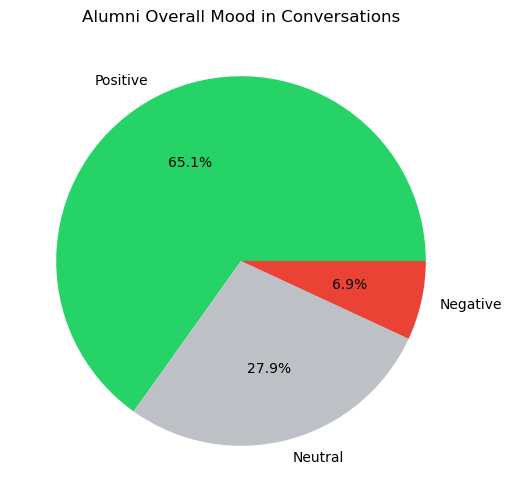

In [18]:
# Count occurrences of each mood
mood_counts = df["mood"].value_counts()

# Plot the mood distribution
plt.figure(figsize=(6, 6))
plt.pie(mood_counts, labels=mood_counts.index, autopct="%1.1f%%", colors=["#25D366", "#BDC1C6", "#EA4335"])
plt.title("Alumni Overall Mood in Conversations")
plt.show()

#### - Word Cloud

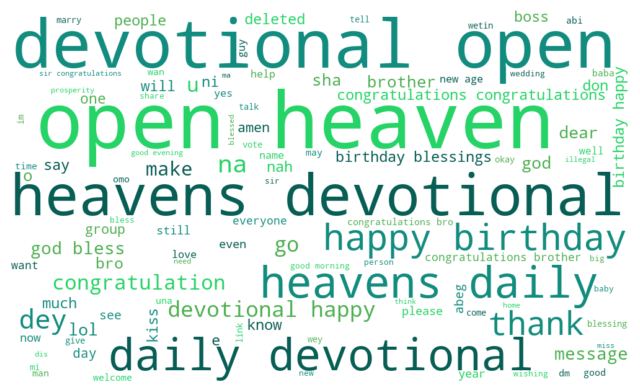

In [19]:
# Color map with shades of green
shades_of_green = ["#4CAF50", "#25D366", "#128C7E", "#075E54"]

# Generate and plot the word cloud
plt.figure(figsize=(8, 8))
wordcloud = WordCloud(width=1000, height=600, background_color="white", 
                      colormap="Greens", stopwords=STOPWORDS, 
                      min_font_size=12, contour_color='black', contour_width=1).generate(text)

# Apply green color map
wordcloud.recolor(color_func=lambda *args, **kwargs: np.random.choice(shades_of_green))

# Show the word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### - Peak Engagement Dates

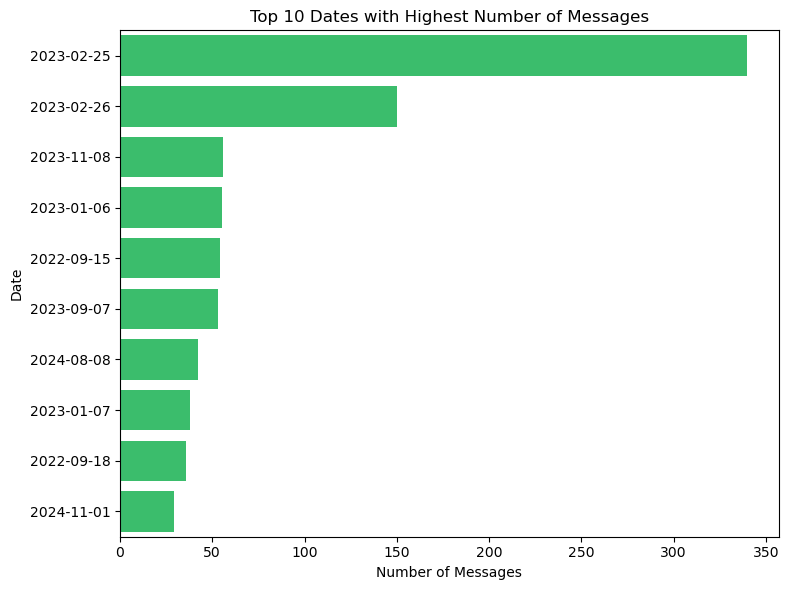

In [20]:
# Prepare the data
top_dates = df['date'].value_counts().head(10).reset_index()
top_dates.columns = ['date', 'count']

# Plot using Matplotlib and Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='date', data=top_dates, color='#25D366')  # WhatsApp Green
plt.title('Top 10 Dates with Highest Number of Messages')
plt.xlabel('Number of Messages')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

#### - Peak Interaction Times

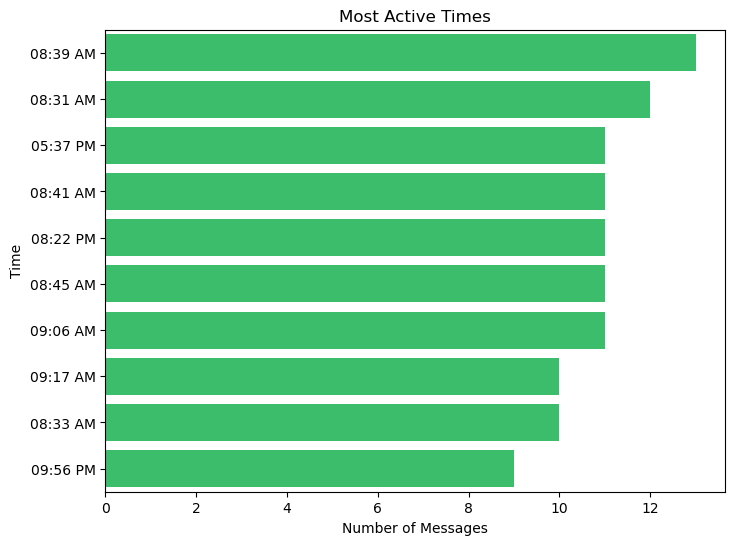

In [21]:
# Convert time to string format (if not already) and remove any seconds
df['time'] = pd.to_datetime(df['time'].astype(str).str[:5], format='%H:%M').dt.strftime('%I:%M %p')

# Prepare the data for the top 10 most active times
top_times = df['time'].value_counts().head(10).reset_index()
top_times.columns = ['time', 'count']

# Plot using Matplotlib and Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='time', data=top_times, color='#25D366')
plt.title('Most Active Times')
plt.xlabel('Number of Messages')
plt.ylabel('Time')
plt.show()


#### - Peak Engagement Hours

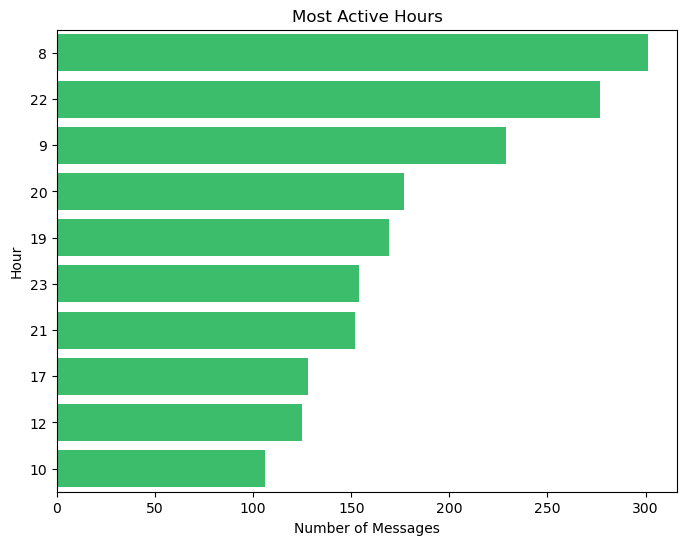

In [22]:
# Prepare the data for the top 10 most active hours
top_hours = df['hour'].value_counts().head(10).reset_index()
top_hours.columns = ['hour', 'count']

# Sort the data by hour to ensure proper order
top_hours['hour'] = top_hours['hour'].astype(str)  # Convert to string for categorical sorting
top_hours.sort_values(by='count', ascending=False, inplace=True)

# Plot a horizontal bar chart with hour as the y-axis
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='hour', data=top_hours, color='#25D366')
plt.title('Most Active Hours')
plt.xlabel('Number of Messages')
plt.ylabel('Hour')
plt.show()

#### - Peak Engagement Days

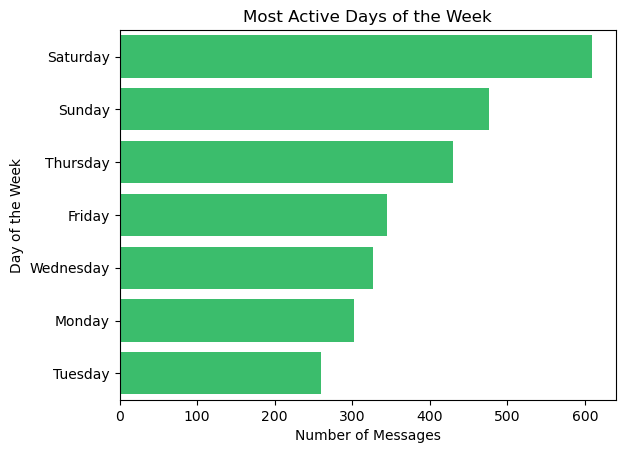

In [23]:
# Prepare the data: extract day of the week and count occurrences
top_days = df['date'].apply(lambda x: pd.to_datetime(x).day_name()).value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index(name='count')

top_days.columns = ['day_of_week', 'count']  # Rename 'index' to 'day_of_week'

# Sort and plot
top_days.sort_values(by='count', ascending=False, inplace=True)
sns.barplot(x='count', y='day_of_week', data=top_days, color='#25D366')
plt.title('Most Active Days of the Week')
plt.xlabel('Number of Messages')
plt.ylabel('Day of the Week')
plt.show()


#### - Engagement Heatmap

In [24]:
# Aggregate by hour and day of the week
heatmap_data = df.groupby([df['day_of_week'], df['hour']])['word_count'].sum().unstack()
fig = px.imshow(heatmap_data, labels={'x': 'Hour of Day', 'y': 'Day of Week'}, title="Message Heatmap by Time and Day")
fig.show()

## Spotting Influential Alumni

#### - Top Contributors

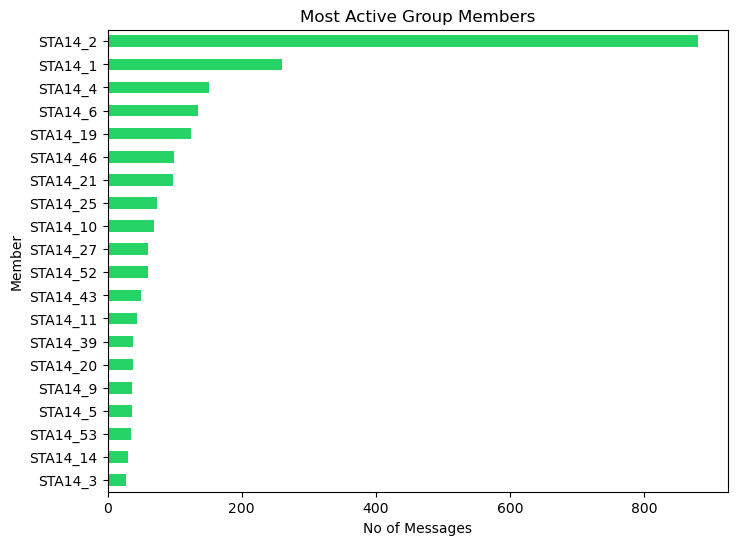

In [25]:
df['member'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh',figsize=(8,6), color='#25D366')
plt.title('Most Active Group Members')
plt.ylabel('Member')
plt.xlabel('No of Messages');

#### - Least Contributing Members

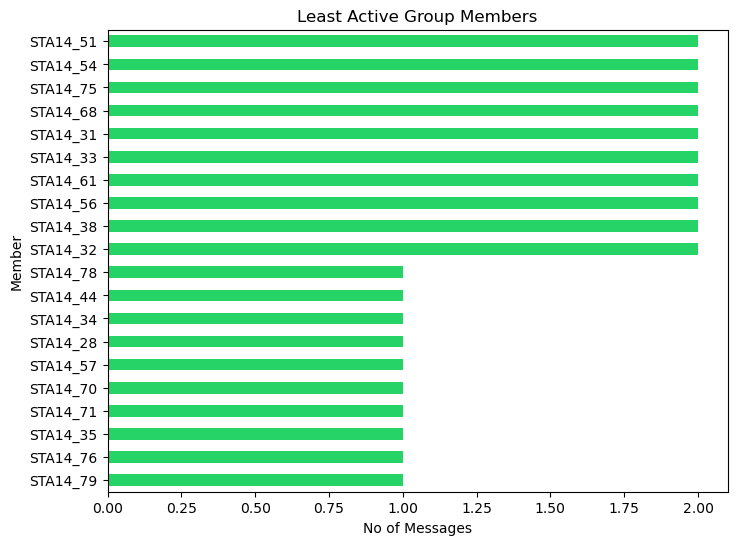

In [26]:
df['member'].value_counts().tail(20).sort_values(ascending=True).plot(kind='barh',figsize=(8,6), color='#25D366')
plt.title('Least Active Group Members')
plt.ylabel('Member')
plt.xlabel('No of Messages');

#### - Monthly Messaging Trends

In [27]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Group by month for a bar plot of message counts
df['month'] = df['date'].dt.to_period('M').astype(str)  # Convert to string for better formatting
monthly_df = df.groupby('month')['word_count'].sum().reset_index()

# Create a figure with both bar and line traces
fig = go.Figure()

# Add bar trace
fig.add_trace(go.Bar(x=monthly_df['month'], y=monthly_df['word_count'], name='Message Count', 
                     marker_color='#25D366'))

# Add line trace (representing the trend of message count)
fig.add_trace(go.Scatter(x=monthly_df['month'], y=monthly_df['word_count'], mode='lines+markers', name='Trend',
                         line=dict(color='red', width=2)))

# Update layout and axes
fig.update_layout(title="Monthly Messaging Progression",
                  xaxis_title="Month", yaxis_title="Number of Messages",
                  xaxis_tickangle=45)

fig.show()


## Topic Modeling with Latent Dirichlet Allocation 

Latent Dirichlet Allocation (LDA) is a statistical model that is used for identifying thematic structures in a collection of documents or texts. This is a model that uses the Dirichlet distribution (a probability distribution that defines the likelihood of selecting certain topics) to model the distribution of topics within each document and the distribution of words within each topic.

Employing LDA, I will be able to provide insights into the dominant topics or themes being discussed in the chat group. For instance, conversations focus on nostalgic chats, reunions, personal milestones, birthdays, celebrations, and so on.

#### - Stopword Removal & Tokenization
Here, I cleaned the text by removing numbers, special characters, and stopwords, then broke it into tokens before vectorization

In [28]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [29]:
def preprocess(text):
    text = re.sub(r'@\d+|\b\d+\b|[^a-zA-Z\s]', '', text.lower())  # Remove numbers, special chars, and mentions
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization & stopword removal
    return words  # Keep as a list for topic modeling
    
# Apply preprocessing function
df['processed_message'] = df['message'].apply(preprocess)

# Convert lists back to strings for LDA
df['processed_message'] = df['processed_message'].apply(lambda x: ' '.join(x))

In [30]:
df['processed_message'] 

0                      moving uk via study rough estimate
1                                  open heaven devotional
2       httpstwittercomeasyfckingmoneystatustjclksmscv...
5                                    open heaven devotion
6                                  open heaven devotional
                              ...                        
3086                                         allah rahman
3087                                       happy birthday
3088                               birthday blessing sire
3089                          thanks gallant statistician
3090                         open heaven daily devotional
Name: processed_message, Length: 2748, dtype: object

#### - TF-IDF vectorizer (only applicable to SKLEARN LDA model)

In [31]:
# Initialize the TF-IDF vectorizer
#vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform
#X_tfidf = vectorizer.fit_transform(df['processed_message'])

#### - Convert text data into a usable format for LDA

In [32]:
dictionary = corpora.Dictionary([text.split() for text in df['processed_message']])
corpus = [dictionary.doc2bow(text.split()) for text in df['processed_message']]

#### - Bayesian Optimization (Optuna) Hyperparameter Tuning

Write the objective function for Optuna model tuning

In [33]:
def objective(trial):
    num_topics = trial.suggest_int("num_topics", 5, 50)  # Tune number of topics
    alpha = trial.suggest_float("alpha", 0.01, 1, log=True)   # Use suggest_float with log=True
    beta = trial.suggest_float("beta", 0.01, 1, log=True)     # Same for beta

    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        eta=beta,
        passes=10
    )

    coherence_model = CoherenceModel(model=lda_model, texts=[text.split() for text in df['processed_message']], dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Run Bayesian Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # 30 trials

print("Best Parameters:", study.best_params)


[I 2025-03-15 03:19:18,557] A new study created in memory with name: no-name-02b645a5-94a9-4115-a043-7a2d65a64eb9
[I 2025-03-15 03:19:27,777] Trial 0 finished with value: 0.5319099238673818 and parameters: {'num_topics': 46, 'alpha': 0.9147755500848866, 'beta': 0.5754085677460908}. Best is trial 0 with value: 0.5319099238673818.
[I 2025-03-15 03:19:44,460] Trial 1 finished with value: 0.5012304556880539 and parameters: {'num_topics': 25, 'alpha': 0.39947186375543914, 'beta': 0.03345480463392182}. Best is trial 0 with value: 0.5319099238673818.
[I 2025-03-15 03:19:51,886] Trial 2 finished with value: 0.4594898196595987 and parameters: {'num_topics': 15, 'alpha': 0.025255331504493512, 'beta': 0.6961490309188795}. Best is trial 0 with value: 0.5319099238673818.
[I 2025-03-15 03:20:08,017] Trial 3 finished with value: 0.47680420088241504 and parameters: {'num_topics': 23, 'alpha': 0.30249376482727675, 'beta': 0.9707071721902875}. Best is trial 0 with value: 0.5319099238673818.
[I 2025-03-1

Best Parameters: {'num_topics': 35, 'alpha': 0.9818770834709173, 'beta': 0.08165906756398034}


In [34]:
best_params = study.best_params

lda_best = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_params['num_topics'],
    alpha=best_params['alpha'],
    eta=best_params['beta'],
    passes=10,
    random_state=42
)

#### - Extract the most representative words from each topic

In [35]:
# Extract Top Words for Each Topic
topics = lda_best.show_topics(num_topics=best_params["num_topics"], num_words=10, formatted=False)

for i, topic in topics:
    words = [word[0] for word in topic]
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: bless, heaven, open, devotional, god, daily, dear, congratulation, yes, union
Topic 1: heaven, devotional, open, daily, dear, happy, birthday, give, call, invite
Topic 2: devotional, heaven, open, know, congratulation, even, welcome, edited, na, daily
Topic 3: devotional, open, heaven, daily, birthday, vote, b, remember, tuesday, congratulation
Topic 4: heaven, open, blessing, devotional, birthday, daily, happy, wan, congratulation, thanks
Topic 5: devotional, mi, open, heaven, year, sure, happiest, daily, stay, ti
Topic 6: devotional, open, please, birthday, heaven, happy, thanks, god, thank, daily
Topic 7: heaven, open, devotional, pastor, daily, congratulation, thing, evening, birthday, k
Topic 8: devotional, heaven, open, name, daily, birthday, dm, happy, right, na
Topic 9: open, devotional, heaven, nah, daily, sir, birthday, first, wow, whats
Topic 10: open, heaven, devotional, wish, daily, illegal, birthday, happy, heart, picture
Topic 11: heaven, devotional, open, kiss,

#### - Topic Labels with Word Weights

In [42]:
# Sort topics by topic ID before printing
topic_sorted = sorted(topics, key=lambda x: x[0])

for topic_id, topic_words in topic_sorted:
    print(f"Topic {topic_id}:")
    for word, weight in topic_words:
        print(f"   {word}: {weight:.4f}")

Topic 0:
   bless: 0.0916
   heaven: 0.0849
   open: 0.0839
   devotional: 0.0726
   god: 0.0453
   daily: 0.0328
   dear: 0.0230
   congratulation: 0.0219
   yes: 0.0212
   union: 0.0208
Topic 1:
   heaven: 0.1328
   devotional: 0.1111
   open: 0.1016
   daily: 0.0466
   dear: 0.0280
   happy: 0.0191
   birthday: 0.0171
   give: 0.0114
   call: 0.0105
   invite: 0.0104
Topic 2:
   devotional: 0.0877
   heaven: 0.0747
   open: 0.0544
   know: 0.0480
   congratulation: 0.0352
   even: 0.0338
   welcome: 0.0322
   edited: 0.0299
   na: 0.0256
   daily: 0.0238
Topic 3:
   devotional: 0.1370
   open: 0.1328
   heaven: 0.1232
   daily: 0.0607
   birthday: 0.0191
   vote: 0.0172
   b: 0.0167
   remember: 0.0142
   tuesday: 0.0127
   congratulation: 0.0125
Topic 4:
   heaven: 0.1276
   open: 0.1016
   blessing: 0.0827
   devotional: 0.0811
   birthday: 0.0469
   daily: 0.0293
   happy: 0.0213
   wan: 0.0184
   congratulation: 0.0160
   thanks: 0.0147
Topic 5:
   devotional: 0.0586
   mi: 0.05

#### - Manually assigned topic labels

In [ ]:
# Assign Meaningful Labels
topic_labels = {
    0: "Blessings & Devotion",
    1: "Religious Messages",
    2: "Encouragement & Celebration",
    3: "Faith & Reminders",
    4: "Spiritual Blessings",
    5: "Well-wishes & Faith",
    6: "Prayers & Appreciation",
    7: "Religious Leadership & Faith",
    8: "Names & Recognition",
    9: "Expressions of Faith",
    10: "Faith & Reflection",
    11: "Celebratory Messages",
    12: "Education & Opportunities",
    13: "Daily Devotionals & Encouragement",
    14: "Religious Greetings",
    15: "Casual Conversations",
    16: "Moral & Spiritual Advice",
    17: "Thanksgiving & Well-wishes",
    18: "Support & Encouragement",
    19: "Birthday & Congrats Messages",
    20: "Birthday Wishes",
    21: "Religion & Education",
    22: "Casual & Conversational",
    23: "Faith & Devotion",
    24: "Casual & Encouraging Messages",
    25: "Community & Togetherness",
    26: "Faith & Humor",
    27: "Daily Spiritual Growth",
    28: "Faith & Social Topics",
    29: "Career & Tech Discussions",
    30: "Faith & Personal Growth",
    31: "Islamic Prayers",
    32: "Gratitude & Well-wishes"
}

####  - Topic model visualization
`pyLDAvis` is a LDA topic modeling visualization output. It commonly used in Natural Language Processing (NLP) to identify hidden topics in textual data. The plot uses multidimensional scaling (MDS) to display how topics relate to each other.

In [ ]:
vis = gensimvis.prepare(lda_best, corpus, dictionary)

# Replace topic numbers with labels
for i, label in topic_labels.items():
    vis.topic_info.iloc[i, 0] = label

#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_visualization.html')

In [63]:
pyLDAvis.display(vis)




#### - Quick explainer

(i) Overview

* With most of the topics clustered together, Topic 4 appears to standout separately from the rest, suggesting a unique discussion theme.

* Looking at the bar chart, terms like `Blessings & Devotion`, `Religious Messages` and `Encouragement & Celebration` appear most frequently, indicating the dataset heavily revolves around faith-based conversations.

*  Some less frequent but still relevant themes include `Career & Tech Discussions` and `Faith and Social Topics`, showing that while faith dominates, other discussions exist.

(ii) On Topic 4

*  This topic likely represents messages related to *birthday celebrations, well-wishing, and encouragement*

*  It is more distinct from others, which could indicate that birthday greetings have a unique conversational structure compared to general religious discussions/posts.

*  The presence of personal names like `tunde`, `amadi`, and `jide` suggests that these messages might be directed at individuals rather than general community-wide blessings.





 #### - export model

In [40]:
lda_best.save("lda_best_model.gensim")  # Save the best LDA model
dictionary.save("lda_dictionary.gensim")  # Save the dictionary
gensim.corpora.MmCorpus.serialize("lda_corpus.mm", corpus)  # Save the corpus

## Interaction Network

In [ ]:

# Create a directed graph
G = nx.DiGraph()

# Add edges based on messages sent by each member
for index, row in df.iterrows():
    sender = row["member"]
    
    # Extract last four digits if the mention is a number, otherwise keep it as is
    mentioned_users = [word.strip("@")[-4:] if word.strip("@").isdigit() else word.strip("@") 
                       for word in row["message"].split() if word.startswith("@")]
    
    for mentioned in mentioned_users:
        G.add_edge(sender, mentioned, weight=1)

# Compute positions using a layout algorithm
pos = nx.spring_layout(G, seed=42)  # Consistent node positioning

# Create edge coordinates
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])  # 'None' to separate edges
    edge_y.extend([y0, y1, None])

# Create node coordinates
node_x = []
node_y = []
node_text = []
node_hover_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    # Default text (no @)
    node_text.append(node)
    
    # Hover text (with @)
    node_hover_text.append(f"@{node}")  

# Compute degree centrality for node coloring
centrality = nx.degree_centrality(G)
node_color = [centrality[node] for node in G.nodes()]
node_size = [10 + (cent * 50) for cent in centrality.values()]  # Adjust node size dynamically

# Create edge trace (gray edges)
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),  
    hoverinfo='none',
    mode='lines'
)

# Create node trace (green nodes with dark theme)
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,  # Show names without "@"
    textposition="top center",
    hoverinfo='text',
    hovertext=node_hover_text,  # Show full mention with "@" on hover
    marker=dict(
        showscale=True,
        colorscale='darkmint',  
        color=node_color,
        size=node_size,
        colorbar=dict(
            thickness=15,
            title=dict(text="Node Centrality"),
            xanchor='left'
        ),
        line=dict(width=2, color='green')  # Black outline for node visibility
    )
)

# Create the figure with layout inside go.Figure()
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='WhatsApp Interaction Network',
        title_font=dict(color='white', size=18),
        showlegend=False,
        hovermode='closest',
        plot_bgcolor='rgb(18, 18, 18)',  
        paper_bgcolor='rgb(18, 18, 18)',  
        font=dict(color='rgb(200,200,200)', size=12),  # Dimmer font color
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        margin=dict(l=0, r=0, b=0, t=40),
        hoverlabel=dict(
            bgcolor="rgba(0,0,0,0.8)",  
            font=dict(color="green")
        )
    )
)

# Show
fig.show()


#### - Interpretation 

* The most active participants `@STA14_1` and `@STA14_6` forms the core of the network. `@STA14_1` has the largest node in the network indicating an alumnus with more direct connections (i.e., interact with many group members).

* The central region contains handful of clustered nodes one of such containing `@STA14_1`, `@STA14_6`, `@STA14_9`, `@STA14_46`, `@STA14_52`, and `@STA14_5`, showing high activity levels among certain members.

* Nodes like `@Damilola`, `@~Jadesola`, `@Muyiwa` and many others have only one or two connections, suggesting minimal engagement (e.g., occasional messages or replies).

* Many nodes are sparsed out or positioned toward the outer edges, indicating members or stats alumni with fewer interactions in the chat group.

* Also, nodes that are loosely connected indicate alumni that interact with only a few members in the chat.

#### *Let's call it the end*